In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
# Importar data
filename = 'data/garments_worker_productivity.csv'
data = pd.read_csv(filename)

In [3]:
# Obtener el tamaño del conjunto de datos
print(data.shape)

(1197, 15)


In [4]:
# Obtener el detalle de la información
# Se observa que la columna wip presenta valores nulos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [5]:
# Corregir el formato de la columna fecha
data['day'] = data['date'].apply(lambda x: x[:x.find('/')])
data['day'] = data['day'].apply(lambda x: '0' + x if len(x) == 1 else x)
data['month'] = data['date'].apply(lambda x: x[:-4][x.find('/') + 1:-1])
data['month'] = data['month'].apply(lambda x: '0' + x if len(x) == 1 else x)
data['year'] = data['date'].apply(lambda x: x[-4:])

data['date'] = data['day'] + '/' + data['month'] + '/' + data['year']
data['date'] = pd.to_datetime(data['date'], format='%m/%d/%Y')

data['day'] = data['date'].apply(lambda x: x.day)
data['month'] = data['date'].apply(lambda x: x.month)
data['year'] = data['date'].apply(lambda x: x.year)

In [6]:
# Los datos que se analizarán corresponden a los meses de enero, febrero y marzo del 2015
print('Fecha mínima: {}'.format(data['date'].min()))
print('Fecha máxima: {}'.format(data['date'].max()))

Fecha mínima: 2015-01-01 00:00:00
Fecha máxima: 2015-03-11 00:00:00


In [7]:
# Corregir los datos de la columna departament
departamento_valores = {
    'sweing': 'Costura'
    , 'finishing ': 'Acabado'
    , 'finishing':'Acabado'
}
data['department'] = data['department'].map(departamento_valores)

In [8]:
# Agregar si el grupo de trabajo tuvo un incentivo (cantidad mayor a 0) o no
data['tiene_incentivo'] = data['incentive'].apply(lambda x: 1 if x>0 else 0)

In [9]:
# Obtener los valores únicos por columna
data.nunique()

date                      59
quarter                    5
department                 2
day                       30
team                      12
targeted_productivity      9
smv                       70
wip                      548
over_time                143
incentive                 48
idle_time                 12
idle_men                  10
no_of_style_change         3
no_of_workers             61
actual_productivity      879
month                      3
year                       1
tiene_incentivo            2
dtype: int64

In [10]:
# Eliminar la columna año ya que tiene un único valor
data = data.drop(columns=['year'])

In [52]:
# Agregar si hubo un tiempo o trabajadores inactivos en el turno
data['trabajador_inactivo'] = data['idle_men'].apply(lambda x: 1 if x>0 else 0)
data['tiempo_parado'] = data['idle_time'].apply(lambda x: 1 if x>0 else 0)

In [54]:
# Agregar si hubo parada en la producción
data['parada_produccion'] = data['trabajador_inactivo'] + data['tiempo_parado']
data['parada_produccion'] = data['parada_produccion'].apply(lambda x: 1 if x > 0 else 0)

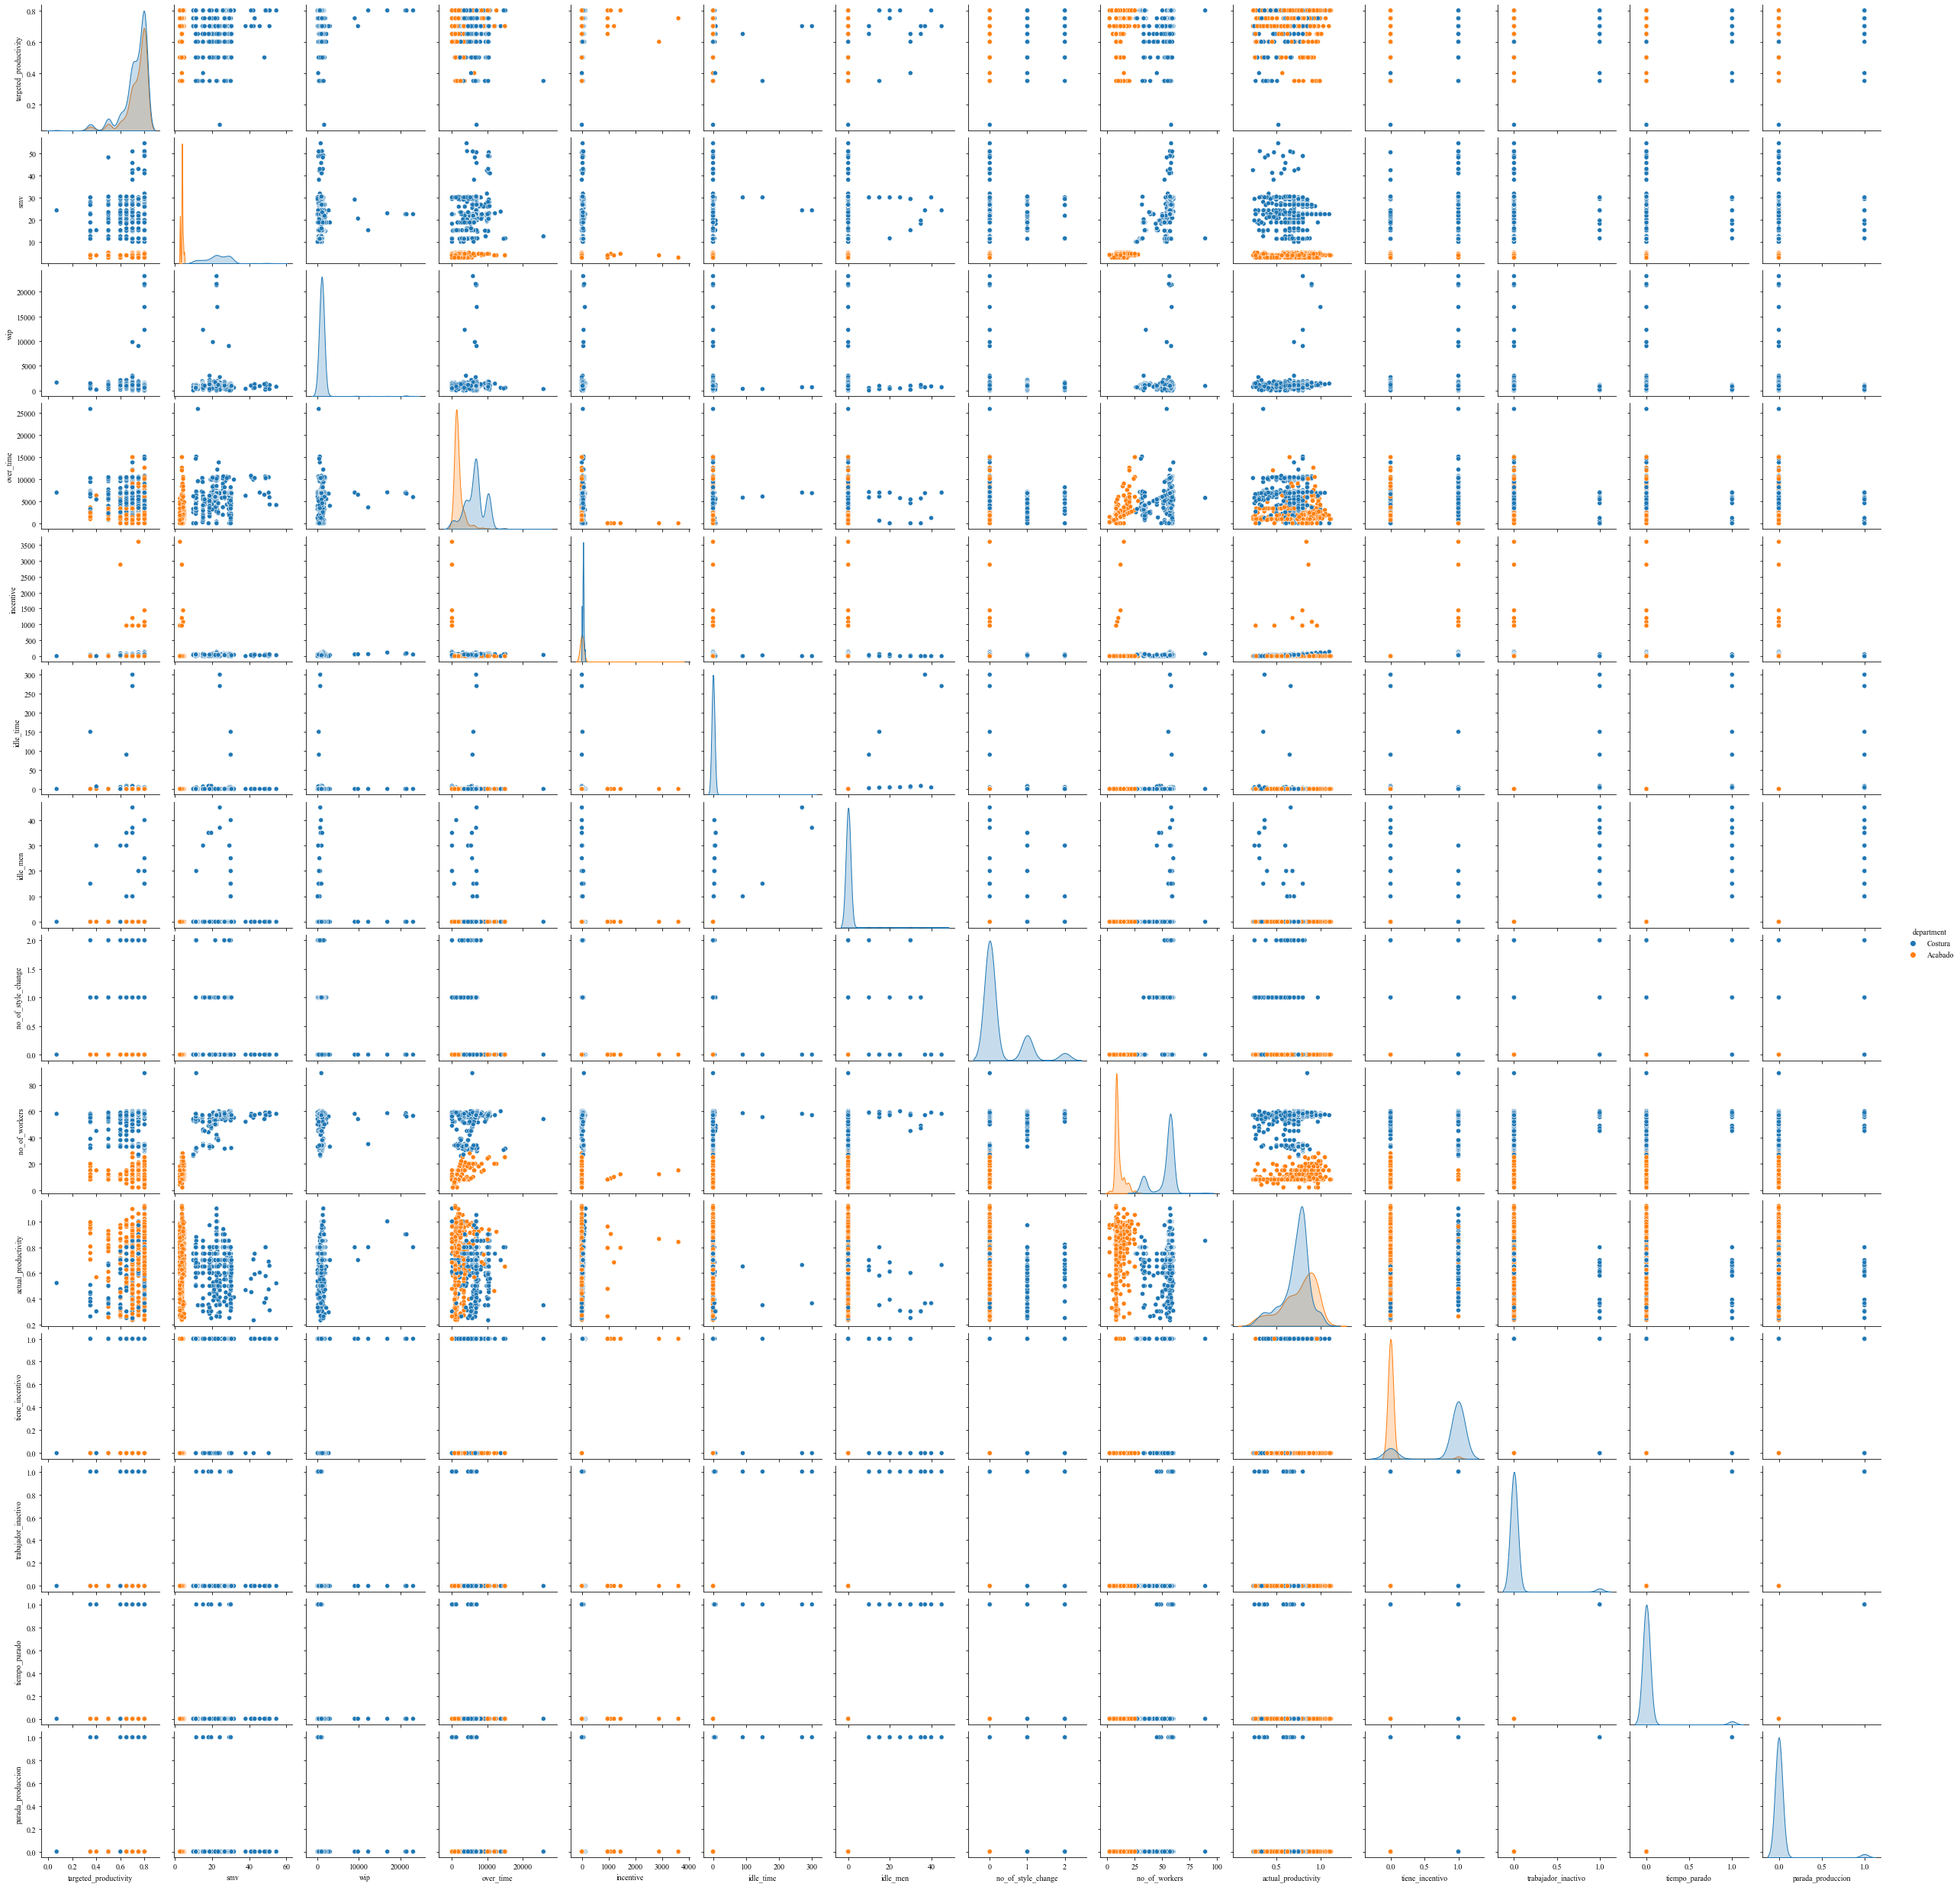

In [55]:
col_interes = data[['targeted_productivity',
       'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men',
       'no_of_style_change', 'no_of_workers', 'actual_productivity',
        'tiene_incentivo', 'trabajador_inactivo', 'tiempo_parado', 'parada_produccion','department']]

sns.pairplot(col_interes, hue='department');

In [56]:
# Tipo de letra a utilizar en los gráficos
plt.rcParams.update({'font.sans-serif':'Times New Roman'})

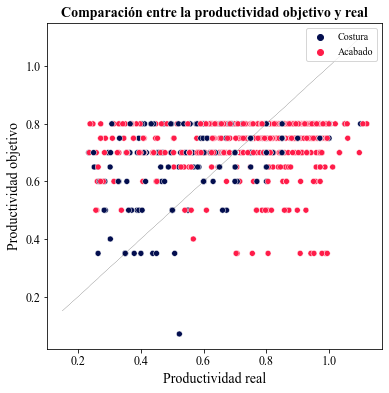

In [61]:
# Existe una diferencia entre la productividad real y la objetivo

palette = ['#030E4F', '#FF1C49']
diagonal_line = np.arange(0.15,1.15,0.05)

plt.figure(figsize=(6, 6))

sns.lineplot(x=diagonal_line, y=diagonal_line, color='#000000', ls='--', linewidth=0.25)
sns.scatterplot(data=data
                , x='actual_productivity'
                , y='targeted_productivity'
                , hue='department'
                , s=35
                , palette=palette)

plt.title('Comparación entre la productividad objetivo y real'
          , fontsize=14
          , weight = 'bold')
plt.ylabel('Productividad objetivo'
           , fontsize=14)
plt.xlabel('Productividad real'
           , fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right')

plt.show()

In [69]:
# Calcular la diferencia entre la productividad real y objetivo. 
# Un número negativo indica que la productividad real estuvo por debajo de la objetivo
data['diferencia_productividad'] = data['actual_productivity'] - data['targeted_productivity']
data['problema_productividad'] = data['diferencia_productividad'].apply(lambda x: 1 if x<0 else 0)

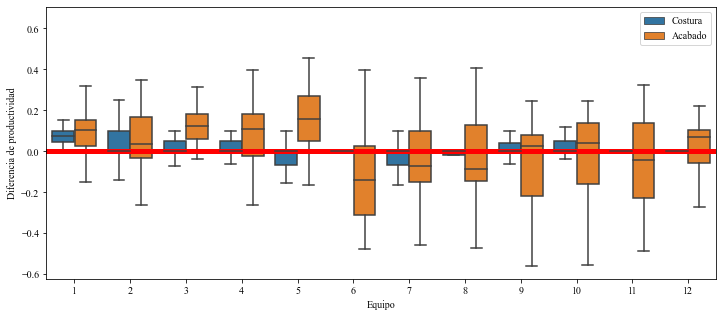

In [79]:
# La productividad de los equipoas 1, 2, 3 y 4 presentan pocos casos de incumplimiento de productividad en relación 
# a los otros equipos

plt.figure(figsize=(12, 5))
sns.boxplot(data=data, y='diferencia_productividad', x='team', hue='department', fliersize=0)
plt.axhline(y=0, color='r', linestyle='-', linewidth= 5)
plt.xlabel('Equipo')
plt.ylabel('Diferencia de productividad')
plt.legend(loc='upper right')
plt.show()

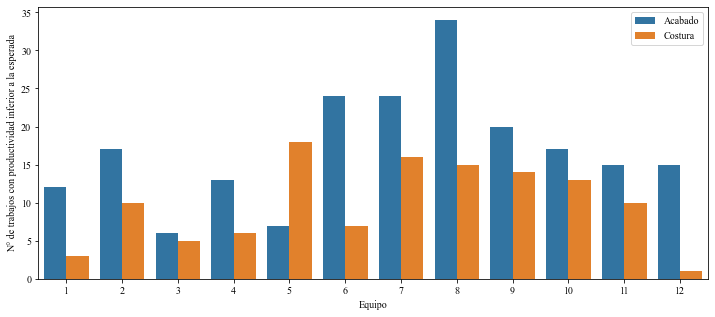

In [85]:
# Número de casos en los que que los equipos obtuvieron una productividad inferior a la esperada

productividad_equipo = data.groupby(['team','department'], as_index=False)['problema_productividad'].sum()

plt.figure(figsize=(12, 5))
sns.barplot(data=productividad_equipo, y='problema_productividad', x='team', hue='department')
plt.ylabel('N° de trabajos con productividad inferior a la esperada')
plt.xlabel('Equipo')
plt.legend(loc='upper right')
plt.show()

In [84]:
# La desviación estándar en las diferencias de productividad son menores para el departamento de costura que varían entre
# 0.01 y 0.14. Esta variación de la desviación estándar para acabado se encuentra entre 0.13 y 0.22

data.groupby(['department','team'])['diferencia_productividad'].describe()

count      mean       std       min       25%       50%  \
department team                                                            
Acabado    1      49.0  0.077803  0.131260 -0.245404  0.028150  0.103667   
           2      52.0  0.027245  0.183248 -0.552684 -0.032584  0.036879   
           3      37.0  0.106787  0.149736 -0.307500  0.060370  0.121704   
           4      46.0  0.102165  0.224219 -0.462958 -0.024589  0.108824   
           5      35.0  0.131600  0.200059 -0.369886  0.050537  0.159564   
           6      35.0 -0.094932  0.264885 -0.478125 -0.310972 -0.139792   
           7      41.0 -0.044643  0.212706 -0.457639 -0.151894 -0.073333   
           8      53.0 -0.020551  0.227392 -0.470455 -0.146402 -0.088021   
           9      46.0 -0.051560  0.193712 -0.561958 -0.216955  0.026868   
           10     43.0 -0.030071  0.208211 -0.553750 -0.160675  0.040533   
           11     29.0 -0.042382  0.222569 -0.486147 -0.229231 -0.041771   
           12     40.0  0.013583  0.155687 -0.528000 -0.055955  0.069091   
Costura    1      56.0  0.071400  0.112250 -0.396758  0.044701  0.075336   
           2      57.0  0.034324  0.137133 -0.488793  0.000070  0.000594   
           3      58.0  0.033060  0.087881 -0.263098  0.000274  0.000557   
           4      59.0  0.013628  0.085636 -0.326865  0.000232  0.000594   
           5      58.0 -0.040410  0.120849 -0.492499 -0.068883  0.000081   
           6      59.0 -0.016969  0.072890 -0.417854  0.000188  0.000359   
           7      55.0 -0.047474  0.147975 -0.433946 -0.067865  0.000241   
           8      56.0 -0.046940  0.127388 -0.398601 -0.019515  0.000313   
           9      58.0 -0.001624  0.087432 -0.302115  0.000035  0.000396   
           10     57.0 -0.010234  0.140959 -0.450583  0.000000  0.000422   
           11     59.0 -0.011971  0.072845 -0.387880  0.000035  0.000230   
           12     59.0 -0.001133  0.019235 -0.137744  0.000253  0.000402   

                      75%       max  
department team                      
Acabado    1     0.155152  0.320437  
           2     0.166914  0.350625  
           3     0.180340  0.372100  
           4     0.183985  0.638636  
           5     0.269267  0.455750  
           6     0.024681  0.627556  
           7     0.099188  0.357639  
           8     0.130417  0.644375  
           9     0.078314  0.244271  
           10    0.136687  0.247792  
           11    0.139514  0.321867  
           12    0.103889  0.221867  
Costura    1     0.100710  0.300484  
           2     0.100478  0.250281  
           3     0.050473  0.250230  
           4     0.050313  0.150556  
           5     0.000603  0.200534  
           6     0.000651  0.087995  
           7     0.000786  0.452845  
           8     0.000632  0.140725  
           9     0.042754  0.220817  
           10    0.050532  0.199995  
           11    0.000511  0.173245  
           12    0.000402  0.050521

In [87]:
# Todas las paradas ocurridas en la planta ocurrieron en el departamento de costura

data.groupby(['department'], as_index=False)[['trabajador_inactivo', 'tiempo_parado']].sum()

,department,trabajador_inactivo,tiempo_parado
0,Acabado,0,0
1,Costura,18,18


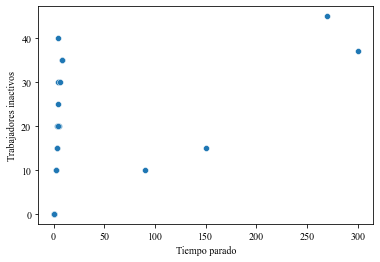

In [90]:
sns.scatterplot(data=data, x='idle_time', y='idle_men')
plt.xlabel('Tiempo parado')
plt.ylabel('Trabajadores inactivos')

plt.show()

In [96]:
data[data['incentive']<3500]

count    1197.000000
mean       38.210526
std       160.182643
min         0.000000
25%         0.000000
50%         0.000000
75%        50.000000
max      3600.000000
Name: incentive, dtype: float64

<AxesSubplot:xlabel='incentive', ylabel='Count'>

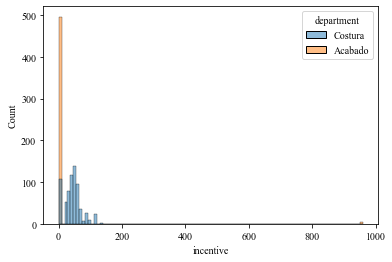

In [100]:
sns.histplot(data=data[data['incentive']<1000], x='incentive', hue='department')

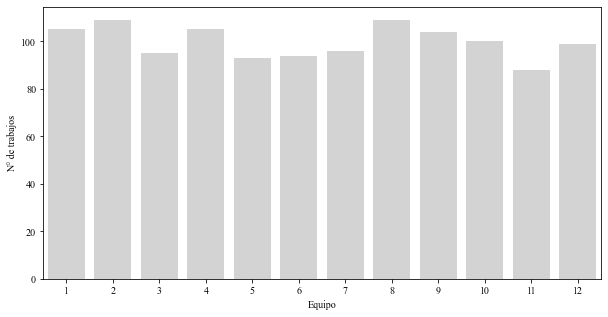

In [91]:
# Número de trabajos realizado por equipo

plt.figure(figsize=(10, 5))

trabajo_por_equipo = data.groupby(['team'], as_index=False)['targeted_productivity'].count()
sns.barplot(data=trabajo_por_equipo, y='targeted_productivity', x='team', color='#d3d3d3')
plt.ylabel('N° de trabajos')
plt.xlabel('Equipo')
plt.show()

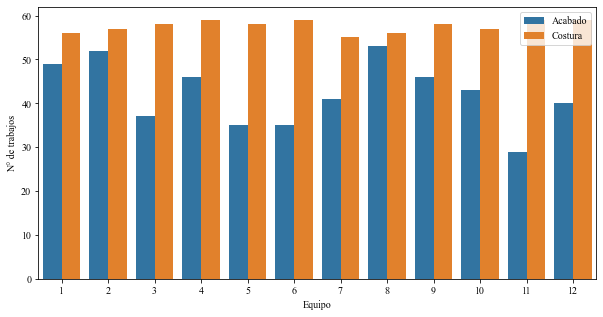

In [92]:
# Todos los equipos realizan trabajos de costura o acabado.
# Se observa que los trabajos de costura se realizan en mayor medida que los de acabado

plt.figure(figsize=(10, 5))

trabajo_por_equipo_departamento = data.groupby(['team', 'department'], as_index=False)['targeted_productivity'].count()
sns.barplot(data=trabajo_por_equipo_departamento, y='targeted_productivity', x='team', hue='department')
plt.ylabel('N° de trabajos')
plt.xlabel('Equipo')
plt.legend(loc='upper right')
plt.show()

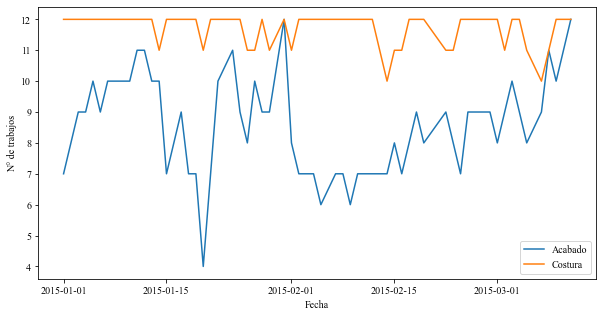

In [93]:
# Los trabajos de costura se mantuvieron casi constantes durante el periodo analizado mientras que los de acabado tuvieron 
# fluctuaciones más notorias

plt.figure(figsize=(10, 5))
trabajo_departamento = data.groupby(['date', 'department'], as_index=False)['team'].count()
sns.lineplot(data=trabajo_departamento, x='date', y='team', hue='department')
plt.ylabel('N° de trabajos')
plt.xlabel('Fecha')
plt.legend(loc='lower right')
plt.show()

In [40]:
data.columns

Index(['date', 'quarter', 'department', 'day', 'team', 'targeted_productivity',
       'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men',
       'no_of_style_change', 'no_of_workers', 'actual_productivity', 'month',
       'tiene_incentivo', 'trabajadores_inactivos', 'parada_produccion',
       'diferencia_productividad'],
      dtype='object')

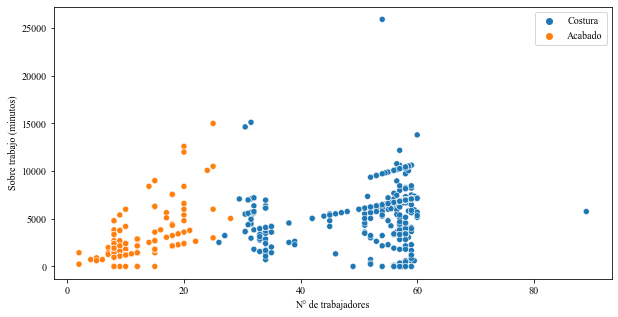

In [24]:
plt.figure(figsize=(10, 5))

sns.scatterplot(data=data, x='no_of_workers', y='over_time', hue='department')
plt.ylabel('Sobre trabajo (minutos)')
plt.xlabel('N° de trabajadores')
plt.legend(loc='upper right')
plt.show()

In [25]:
# En general, para los equipos, el máximo número de trabajadores es de 60
data.groupby(['team'])['no_of_workers'].describe()

,count,mean,std,min,25%,50%,75%,max
team,,,,,,,,
1,105.0,35.042857,24.073517,2.0,8.0,56.5,58.00,59.0
2,109.0,34.623853,22.505365,8.0,10.0,45.0,57.00,59.0
3,95.0,39.521053,22.101063,7.0,12.0,56.0,57.00,60.0
4,105.0,38.200000,22.239799,8.0,15.0,56.0,58.00,60.0
5,93.0,39.381720,23.639319,2.0,12.0,58.0,58.00,60.0
6,94.0,25.170213,14.313043,5.0,8.0,31.5,33.00,89.0
7,96.0,37.098958,23.730906,8.0,8.0,56.0,58.00,60.0
8,109.0,33.490826,24.016389,4.0,8.0,52.0,57.00,60.0
9,104.0,35.211538,23.737817,2.0,8.0,52.0,58.00,59.0


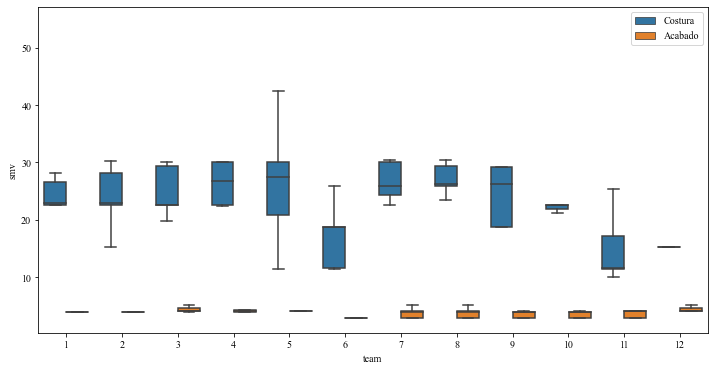

In [26]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=data, x='team', y='smv', hue='department', fliersize=0)
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

sns.scatterplot(data=data, x='no_of_workers', y='targeted_productivity', hue='tiene_incentivo')

plt.show()

In [ ]:
data